<h1>Import necessary libraries</h1>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import logging

2024-04-23 07:05:26.782807: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


<h1>supress warnings</h1>

In [2]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)

<h1>Initiate Hardware</h1>
<h2>Allocate gpu memory</h2>

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.set_logical_device_configuration(
    physical_devices[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=5961),
     tf.config.LogicalDeviceConfiguration(memory_limit=5961)])

  logical_devices = tf.config.list_logical_devices('GPU')
  assert len(logical_devices) == len(physical_devices) + 1

  tf.config.set_logical_device_configuration(
    physical_devices[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=10),
     tf.config.LogicalDeviceConfiguration(memory_limit=10)])
except:
  # Invalid device or cannot modify logical devices once initialized.
  pass

2024-04-23 07:05:28.696836: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-23 07:05:28.698415: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-04-23 07:05:29.857743: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 07:05:29.857860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.59GHz coreCount: 24 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 268.26GiB/s
2024-04-23 07:05:29.857919: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-04-23 07:05:29.860907: I tensorflow/stream_executor/plat

<h1>Building GAN Models</h1>
<h2>Encoder first</h2>
<h4>tf.random_normal_initializer(
    mean=0.0, stddev=0.05, seed=None
)</h4>

## Generator

The generator is a modified version of [U-Net](https://paperswithcode.com/method/u-net).

U-Net components:
* Encoder (downsampler)
* Decoder (upsampler)

More about U-Net:
* https://paperswithcode.com/method/u-net
* https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

**Downsample / encode**
 * Convolution -> Batch normalization -> Leaky ReLU

In [4]:
def encode(fileters, size, apply_batchnorm =True):
    
    # initialize the variables in neural network hidden layer randomly 
    initializer = tf.random_normal_initializer(0.0,0.02,seed=None)

    # buiding encoder below
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.layers.Conv2D(filters=fileters , kernel_size=size, strides = 2, padding='same', kernel_initializer=initializer, use_bias=False))

    # apply batch normalization id apply_batchnorm=True
    if apply_batchnorm:
        encoder.add(tf.keras.layers.BatchNormalization())

    # add activation function leaky_relu
    encoder.add(tf.keras.layers.LeakyReLU())

    # return the encoder 
    return encoder

**Upsample / decode**
 * Transposed convolution -> Batch normalization -> Dropout (applyed for the first 3 blocks) -> ReLU

In [5]:
def decode(fileters, size, apply_dropout = False):
    
    # initialize the variables in neural network hidden layer randomly 
    initializer = tf.random_normal_initializer(0.0,0.02,seed=None)

    # buiding encoder below
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.layers.Conv2DTranspose(filters=fileters , kernel_size=size, strides = 2, padding='same', kernel_initializer=initializer, use_bias=False))

    # apply batch normalization id apply_dropout=True
    if apply_dropout:
        decoder.add(tf.keras.layers.Dropout(0.5))

    # add activation function leaky_relu
    decoder.add(tf.keras.layers.LeakyReLU())

    # return the encoder 
    return decoder

<h1> note that the input to conv nural net has to be in the shape of a float 32 or float 64 none other datatypes are allowed </h1> 

In [6]:
# Loading and preprocessing the image
image_path = "app/img_train/PMC493280_table_0.png"
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image, channels=3)  # Assuming JPEG format
image = tf.cast(image, tf.float32)  # Convert image data to float32
#image = tf.expand_dims(image, 0)  # Adding batch dimension

In [7]:
downsampling_model=encode(3, (8,2))
downsampling_model_result=downsampling_model(tf.expand_dims(image,0))
print(downsampling_model_result.shape)

2024-04-23 07:05:31.612139: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2024-04-23 07:05:36.278297: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


(1, 256, 256, 3)


2024-04-23 07:05:37.436621: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


In [8]:
upsampling_model=decode(3,(8,2))
upsampling_model_result=upsampling_model(downsampling_model_result)
print(upsampling_model_result.shape)

(1, 512, 512, 3)


In [9]:
def make_generator_model():
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])
    
    downsampling=[
        encode(64,4, apply_batchnorm=False), # (batch_size, 256,256,64)
        encode(128,4),  # (batch_size, 128 ,128 ,128)
        encode(256,4),  # (batch_size, 64 ,64 ,256)
        encode(512,4),  # (batch_size, 32 ,32 ,512)
        encode(1024,4),  # (batch_size, 16 ,16 ,1024)
        encode(1024,4),  # (batch_size, 8 ,8 ,1024)
        encode(1024,4),  # (batch_size, 4 ,4 ,1024)
        encode(1024,4),  # (batch_size, 2 ,2 ,1024)
        encode(1024,4),  # (batch_size, 1 ,1 ,1024)
    ]

    upsampling=[
        decode(1024, 4, apply_dropout=True),    #(batch_size, 2,2,1024)
        decode(1024, 4, apply_dropout=True),    #(batch_size, 4,4,1024)
        decode(1024, 4, apply_dropout=True),    #(batch_size, 8,8,1024)
        decode(1024, 4, apply_dropout=True),    #(batch_size, 16,16,1024)
        decode(512, 4, apply_dropout=True),    #(batch_size, 32,32,1024)
        decode(256, 4, apply_dropout=True),     #(batch_size, 64,64,512)
        decode(128, 4, apply_dropout=True),     #(batch_size, 128,128,256)
        decode(64 , 4, apply_dropout=True),     #(batch_size, 256,256,128)
        
    ]

    output_channels=3
    initializer = tf.random_normal_initializer(0.0,0.02,seed=None)
    last = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding="same", kernel_initializer=initializer, activation='tanh') #(batch_size, 512,512,3)
    
    x = inputs
    skips = []
    for down in downsampling:
        x = down(x)
        skips.append(x)
    
    skips=reversed(skips[:-1])

    for up,skip in zip(upsampling,skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x,skip])
    
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

gen=make_generator_model()

In [10]:
dot_img_file = 'app/model_1.png'
tf.keras.utils.plot_model(gen, to_file=dot_img_file, show_shapes=True,dpi = 64)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


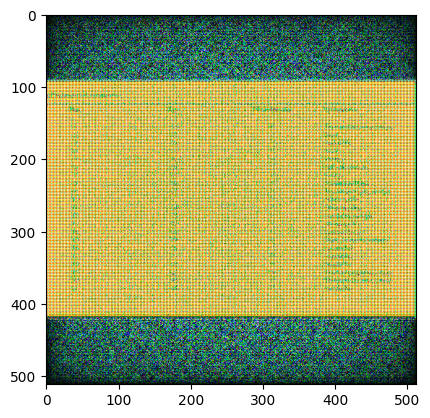

In [11]:
test_output=gen(image[tf.newaxis,...], training=False)
plt.imshow(test_output[0,...])

### Generator loss

Normal GANs learn loss that adapts to the data, while cGAN learns structured loss that penalizes a possible structure that differs from the network output and the expected "real" image. More details: https://arxiv.org/abs/1611.07004

> **Hyperparameters**

Default values suggested in the paper

* Learning rate: 0.0002
* Momentum: [β1, β2] = [0.5, 0.999]
* Lambda (λ_L1) = 100
* The generator loss is a cross-entropy sigmoid of the generated images and an array of 1's
* The pix2pix paper also mentions L1 loss, which is a MAE (Mean Absolute Error) between the generated image and the expected (real) one. This ensures that the generated image becomes structurally similar to the real image.
* The equation for calculating the total loss is gan_loss + LAMBDA * l1_loss where LAMBDA = 100 - this value is also described by the authors of the paper.

In [12]:
lr = 0.0001
beta1, beta2 = 0.5, 0.999
lambda_ = 100

loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_loss(d_generated_output, g_output, target):
    gan_loss = loss(tf.ones_like(d_generated_output), d_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - g_output)) # MAE
    g_loss_total = gan_loss + (lambda_ * l1_loss)
    return g_loss_total, gan_loss, l1_loss

## Discriminator

The discriminator is a [PatchGAN](https://paperswithcode.com/method/patchgan). The goal is to classify if each patch (piece) of the image is real or fake.

* Blocks of the discriminator: Convolution -> Batch normalization -> Leaky ReLU.

* The output shape is `(batch_size, 30, 30, 1)`

More information: https://arxiv.org/abs/1611.07004

The discriminator receives two inputs:
  1. The input image and the expected image, which should be classified as real
  2. The input image and the generated image (fake, generated by the generator), which should be classified as fake.

In [13]:
def make_discriminator_model():
    initializer = tf.random_normal_initializer(0., 0.02)

    original = tf.keras.layers.Input(shape = [512,512,3], name='original_img')
    transformed = tf.keras.layers.Input(shape=[512,512,3], name='transformed_img')
    x = tf.keras.layers.concatenate([original, transformed]) # (batch_size, 256, 256, channels * 2)

    down1 = encode(64, 4, False)(x)   # (batch_size, 256, 256, 64)
    down2 = encode(128, 4)(down1)     # (batch_size, 128, 128, 128)
    down3 = encode(256, 4)(down2)     # (batch_size, 64, 64, 256)
    down4 = encode(512, 4)(down3)     # (batch_size, 32, 32, 512)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(1024, 4, strides = 2, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (batch_size, 31, 31, 512)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (batch_size, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides = 2, kernel_initializer=initializer)(zero_pad2) # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs = [original, transformed], outputs = last)
dis = make_discriminator_model()

In [14]:
tf.keras.utils.plot_model(dis, show_shapes = True, dpi = 64)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


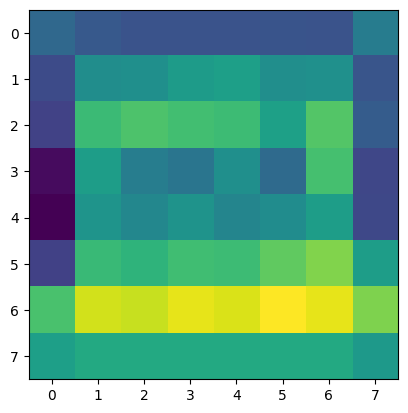

In [15]:
d_output = dis([image[tf.newaxis, ...], test_output], training=False)
plt.imshow(d_output[0, ..., -1])

### Discriminator loss

It receives two inputs: real images and generated (fake) images
* `real_loss` - sigmoid cross-entropy loss comparing the **real** image and one array of 1's
* `generated_loss (fake)` - sigmoid cross-entropy loss comparing the **generated** image and one array of 0's

The total loss is a sum of both losses

In [16]:
def discriminator_loss(mask, generated_mask):
    real_loss = loss(tf.ones_like(mask), mask)
    generated_loss = loss(tf.zeros_like(generated_mask), generated_mask)
    total_loss = real_loss + generated_loss
    return total_loss

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta1, beta_2=beta2)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta1, beta_2=beta2)

In [18]:
""" checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=gen,
                                 discriminator=dis) """

' checkpoint_dir = \'./training_checkpoints\'\ncheckpoint_prefix = os.path.join(checkpoint_dir, "ckpt")\ncheckpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,\n                                 discriminator_optimizer=discriminator_optimizer,\n                                 generator=gen,\n                                 discriminator=dis) '

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output

def display_images(test_image_path, real_image_path, generated_image):
    """
    Display test image, real image, and generated image side by side.
    Args:
        test_image_path (str): Path to the test image.
        real_image_path (str): Path to the real image.
        generated_image (numpy.ndarray): Generated image.
    """
    # Clear the previous output
    clear_output(wait=True)

    # Read and preprocess test image
    test_image_raw = tf.io.read_file(test_image_path)
    test_image_uint8 = tf.image.decode_jpeg(test_image_raw, channels=3)
    
    # Read and preprocess ground truth image
    real_image_raw = tf.io.read_file(real_image_path)
    real_image = tf.image.decode_png(real_image_raw, channels=3)

    # Plotting
    plt.figure(figsize=(20, 16))

    img_list = [test_image_uint8, real_image, generated_image]
    title = ['Input image', 'Real (ground truth)', 'Generated image (fake)']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow(img_list[i])  # Normalize the pixel values
        plt.axis('off')

    plt.show()

In [20]:
import datetime
path_log = 'app/subset_conditional_gan/logs/'
if not os.path.exists(path_log):
    os.makedirs(path_log)
metrics = tf.summary.create_file_writer(path_log + 'fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [21]:
#evaluation metrics function accuracy
def calculate_accuracy(mask_pred, mask_gt):
    """
    Calculate accuracy.
    Args:
        mask_pred (tf.Tensor): Predicted mask.
        mask_gt (tf.Tensor): Ground truth mask.
    Returns:
        float: Accuracy value.
    """
    # Convert masks to binary (0 or 1)
    binary_mask_pred = tf.cast(mask_pred > 127, tf.float32)
    binary_mask_gt = tf.cast(mask_gt > 127, tf.float32)
    # Compare predicted mask with ground truth mask
    correct_predictions = tf.equal(binary_mask_pred, binary_mask_gt)
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy


def calculate_iou(mask_pred, mask_gt):
    """
    Calculate Intersection over Union (IoU).
    Args:
        mask_pred (tf.Tensor): Predicted mask.
        mask_gt (tf.Tensor): Ground truth mask.
    Returns:
        float: IoU value.
    """
    # Convert masks to binary (0 or 1)
    binary_mask_pred = tf.cast(mask_pred > 127, tf.float32)
    binary_mask_gt = tf.cast(mask_gt > 127, tf.float32)
    # Compute intersection
    intersection = tf.reduce_sum(binary_mask_pred * binary_mask_gt)
    # Compute union
    union = tf.reduce_sum(binary_mask_pred) + tf.reduce_sum(binary_mask_gt) - intersection
    # Calculate IoU
    iou = intersection / union
    return iou

## Training

* For each input, an output is generated.
* The discriminator receives input_img and the generated images as the first input. The second input is img_entry and the "real" (expected)
* Then, the loss of the generator and discriminator is calculated
* Then we calculate the loss gradients with respect to the generator and discriminator variables (inputs) and apply these to the optimizer.

In [22]:
def training_step(input_img, real, step):
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generator_output = gen(input_img, training = True)

        discriminator_output_real = dis([input_img, real], training = True)
        discriminator_output_generated = dis([input_img, generator_output], training = True)

        generator_total_loss, generator_loss_gan, generator_loss_l1 = generator_loss(discriminator_output_generated, generator_output, real)
        discriminator_total_loss = discriminator_loss(discriminator_output_real, discriminator_output_generated)

    generator_gradients = generator_tape.gradient(generator_total_loss, gen.trainable_variables)
    discriminator_gradients = discriminator_tape.gradient(discriminator_total_loss, dis.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, dis.trainable_variables))

    # Calculate accuracy
    accuracy = calculate_accuracy(generator_output, real)

    # Calculate IOU 
    iou = calculate_iou(generator_output, real)

    with metrics.as_default():
        tf.summary.scalar('g_total_loss', generator_total_loss, step=step//1000)
        tf.summary.scalar('g_loss_gan', generator_loss_gan, step=step//1000)
        tf.summary.scalar('g_loss_l1', generator_loss_l1, step=step//1000)
        tf.summary.scalar('d_loss', discriminator_total_loss, step=step//1000)

    return generator_total_loss, generator_loss_gan, generator_loss_l1, discriminator_total_loss, accuracy, iou
    

In [23]:
import sys
import time

clipped_output=[]

def print_progress_bar(epoch,total_epochs, batch, total_batches, prefix='', suffix='', total_time=0, time_per_batch=0, accuracy=0, decimals=1, length=100, fill='█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        epoch           - Required  : current epoch (Int)
        batch           - Required  : current batch (Int)
        total_batches   - Required  : total batches (Int)
        prefix          - Optional  : prefix string (Str)
        suffix          - Optional  : suffix string (Str)
        total_time      - Optional  : total time taken for training (Float)
        time_per_batch  - Optional  : time per batch (Float)
        accuracy        - Optional  : accuracy (Float)
        decimals        - Optional  : positive number of decimals in percent complete (Int)
        length          - Optional  : character length of bar (Int)
        fill            - Optional  : bar fill character (Str)
    """
    sys.stdout.write('\r'),
    sys.stdout.flush()
    progress = batch / total_batches
    percent = ("{0:." + str(decimals) + "f}").format(100 * progress)
    bar_length = int(length * progress)
    bar = fill * bar_length + '-' * (length - bar_length)
    for i in clipped_output:
        sys.stdout.write(i)
    sys.stdout.write('\n%s Epoch %d/%d |%s| %s%% | Batch %d/%d | Total Time: %.2f s | Time Per Batch: %.2f ms %s %s \n Accuracy: %.2f' % (prefix, epoch + 1,total_epochs, bar, percent, batch, total_batches, total_time, time_per_batch * 1000, suffix,prefix, accuracy))
    if batch == total_batches:
        clipped_output.append('\n%s Epoch %d/%d |%s| %s%% | Batch %d/%d | Total Time: %.2f s | Time Per Batch: %.2f ms %s %s \n Accuracy: %.2f' % (prefix, epoch + 1,total_epochs, bar, percent, batch, total_batches, total_time, time_per_batch * 1000, suffix,prefix, accuracy))
        sys.stdout.write("\n saving model to .../../../.././//")
    sys.stdout.flush()

In [24]:
import tensorflow as tf
import os
def load_img_fp32(img_list,mask_list,resize_height=None,resize_width=None):
    loaded_images = []
    loaded_masks = []
    
    for img_path, mask_path in zip(img_list, mask_list):
        
        # Load image
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image, channels=3)
        
        # resize images if asked for
        if resize_height is not None and resize_width is not None:
            image = tf.image.resize(image, [resize_height, resize_width])

        # Normalize mask pixel values to be in the range [0, 1]
        image_tensor = tf.cast(image, tf.float32)/255
        
        # append img_tensor to loaded_images
        loaded_images.append(image_tensor)
        
        # Load mask
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=3)
        
        # resize images if asked for
        if resize_height is not None and resize_width is not None:
            mask = tf.image.resize(mask, [resize_height, resize_width])

        # Normalize mask pixel values to be in the range [0, 1]
        mask_tensor = tf.cast(mask, tf.float32) / 255.0
        
        # Append mask tensor to loaded_masks
        loaded_masks.append(mask_tensor)
        
    # Stack tensors along batch dimension
    loaded_images = tf.stack(loaded_images, axis=0)
    loaded_masks = tf.stack(loaded_masks, axis=0)
    
    return loaded_images, loaded_masks

In [27]:
def train(train_images, train_annotations, input_height=None, input_width=None, checkpoints_path=None, epochs=1, batch_size=2, batch_per_epoch=2, 
          validate=True, val_images=None, val_annotations=None, val_batch_size=None, val_steps_per_epoch=None, 
          visualization=False, test_img=None, test_annotation=None):
    
    inp_image_paths=[os.path.join(train_images,i) for i in os.listdir(train_images)]
    
    # see if visualization is set to true if so test model over test set and visualize at the time of some batches has been processed
    if visualization:
        assert test_img is not None
        assert test_annotation is not None
        test_image_paths=[os.path.join(test_img,i) for i in os.listdir(test_img)]
        vis_point=batch_per_epoch/len(test_image_paths)

    # see if validation is true then a validation measurement will be shown at end of training
    if validate:
        assert val_images is not None
        assert val_annotations is not None
        val_image_paths=[os.path.join(val_images,i) for i in os.listdir(val_images)]

    # iterate from no of time we want to tain our model named epoch
    for x in range(epochs):

        # as 1 epoch will result in complete iteration over data so our initial list will be empty after 1 epoch 
        # but if we are check our inp_image has less no of images for a batch requires then extend the inp_image_paths list with new entries
        if len(inp_image_paths)<batch_size:

            #used extend instead of append because append will cause the list to be superimposed [1,2,3,[12,234,45,5,0]]insted of concatination [1,2,3,12,234,45,5,0]
            #also will work if batch_per_epoch will run out of samples due to error calculation
            inp_image_paths.extend([os.path.join(train_images,i) for i in os.listdir(train_images)])

        # iterate in no of batchs we want to train during 1 epoch name batch_per_epoch also called steps
        for y in range(batch_per_epoch):

            # load batch image not in memory but in a list and find paired_data image and corresponding mask
            load_img = inp_image_paths[:batch_size]
            
            # update initial list delete top elments of no of as batchsize because that has been already loaded for training 
            del inp_image_paths[:batch_size]

            # load paired mask list
            load_mask = [os.path.join(train_annotations,os.path.basename(i).replace(".jpg",".png")) for i in load_img]

            # load above paired data into memory
            img,mask=load_img_fp32(load_img,load_mask,input_height,input_width)

            # train and obtain results
            generator_total_loss, generator_loss_gan, generator_loss_l1, discriminator_total_loss, accuracy, iou = training_step(img,mask,batch_per_epoch)
            
            # print in visualization  
            print_progress_bar(x , epochs, y , batch_per_epoch , prefix='', 
            suffix='generator_total_loss = {} | generator_loss_gan = {} | generator_loss_l1 = {} | discriminator_total_loss = {} | iou = {}'.format(generator_total_loss, generator_loss_gan, generator_loss_l1, discriminator_total_loss,iou)
            , total_time=0, time_per_batch=0, accuracy=accuracy, decimals=1, length=100, fill='█')

            if visualization:
                if y%vis_point==0:
                    # load 1 image path out of test set
                    load_test_image=test_image_paths[:1]

                    # delete loaded image path from array
                    del test_image_paths[:1]

                    # load paired mask path 
                    load_mask = [os.path.join(test_annotation,os.path.basename(i).replace(".jpg",".png")) for i in load_test_image]

                    # load images in memory for calulation
                    img, mask = load_img_fp32(load_test_image,load_mask)
                    
                    # predict image from generator model but don't train over it
                    generated_image=gen(img, training = False)

                    #remove batch number from generated image
                    generated_image = generated_image[0]
                    
                    #finally display the imags
                    display_images(load_test_image[0],load_mask[0],generated_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


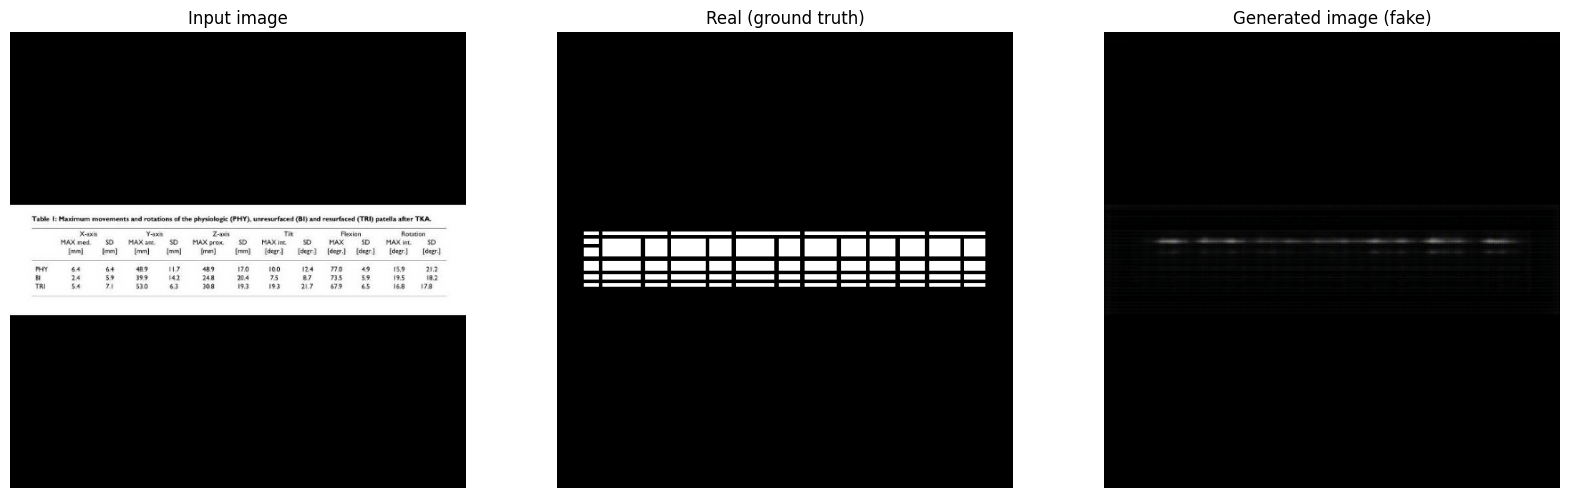


 Epoch 1/1 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.5% | Batch 637/640 | Total Time: 0.00 s | Time Per Batch: 0.00 ms generator_total_loss = 17.898725509643555 | generator_loss_gan = 1.8158650398254395 | generator_loss_l1 = 0.1608286052942276 | discriminator_total_loss = 1.1943955421447754 | iou = nan  
 Accuracy: 1.00
 Epoch 1/1 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.7% | Batch 638/640 | Total Time: 0.00 s | Time Per Batch: 0.00 ms generator_total_loss = 9.133939743041992 | generator_loss_gan = 0.5021834373474121 | generator_loss_l1 = 0.08631756156682968 | discriminator_total_loss = 1.407974362373352 | iou = nan  
 Accuracy: 1.00
 Epoch 1/1 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.8% | Batch 639/640 | Total Time: 0.00 s | Time Per Batch: 0.00 ms generator_total_loss = 9.288413047790527 | ge

In [28]:
train(train_images="app/subset_conditional_gan/train_img/", train_annotations="app/subset_conditional_gan/train_ano/", input_height=None, input_width=None, checkpoints_path=None, 
        epochs=1, batch_size=2, batch_per_epoch=640, validate=False, val_images=None, val_annotations=None, val_batch_size=None, 
        val_steps_per_epoch=None, visualization=True, test_img="app/subset_conditional_gan/test_img", test_annotation="app/subset_conditional_gan/test_ano")